First I need to get the data from my google drive and unzip it.

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

In [0]:
#import zipfile
#with zipfile.ZipFile("./drive/My Drive/train.zip", 'r') as zip_ref:
#    zip_ref.extractall("./data")

In [0]:
#!ls ./data/train

# ResNet CNN for classifiying cats and dogs
This Asirra (Animal Species Image Recognition for Restricting Access) data set is a  HIP (Human Interactive Proof) that works by asking users to identify photographs of cats and dogs. It contains pictures of cats and dogs which can be used to train an image classifier. This time it does not originate from the UCI machine learning repository, but from a [Kaggle competition](https://www.kaggle.com/c/dogs-vs-cats) which was hosted in 2013.

Since my crappy old laptop only as a weak CPU but I want to use GPUs, I'm actually running this project on Google colab.

## Frame the problem
We have a balanced data set of 25000 images of cats and dogs to train a classifier which can tell them apart. While the number of images is not super small, it is still far from enough to easily train any kind of neural network. We will use convolutional neural networks (CNN) which recognize image features much more data-efficiently than fully connected networks. Do artificially enlarge the data set and counter overfitting, we will use data augmentation techniques to modify the images before we pass them into the CNN. Instead of freely experimenting with the CNN architecture, we will choose an architecture which has proven to work very well in past benchmark tests: the ResNet. Furthermore, we will try to train this network from scratch as well as using a network which was trained on the [ImageNet](http://www.image-net.org/) data set to see how much performance we can gain by using pretrained weights. Let's get started!

In [4]:
%pip install tensorflow-addons
%pip install tensorflow-gpu
# import the libraries we'll need
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
import os

## Preparing the data
First we have to set up a pipeline to get the images and then prepare the image augmentation. Let's load the file paths and labels into a data frame first.

In [0]:
data_path = "./data/train/"
filenames = os.listdir(data_path)
labels = []
for filename in filenames:
    label = filename.split('.')[0]
    if label == 'dog':
        labels.append("dog")
    else:
        labels.append("cat")

df = pd.DataFrame({
    'filename': filenames,
    'label': labels
})

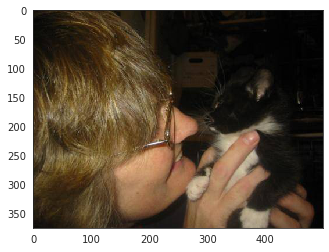

In [6]:
# let's look at a random image
plt.imshow(keras.preprocessing.image.load_img(data_path+df.iloc[100].filename))

Yep, that looks like a cat. Let's first split off training, validation, and test.

In [0]:
train_df_full, test_df = train_test_split(df, test_size=0.20, random_state=42)
train_df, validate_df = train_test_split(train_df_full, test_size=0.25, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

Let's define some constants which we'll use later.

In [0]:
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
CLASS_NAMES = np.array(["dog","cat"])
BATCH_SIZE=64
AUTOTUNE = tf.data.experimental.AUTOTUNE

# tell Tensorflow to use XLA (accelerated linear algebra)
tf.config.optimizer.set_jit(True)

Now we can prepare a generator to stream from for training the model. Keras' image preprocessing utilities provide a function for this. For the training data, we'll implement the augmentation as well.

In [9]:
# The image generator for the training data will apply augmentation operations
# such as rotation, shear, zoom, shifting and horizontal flipping.
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# we will then let the generator stream the data from the filenames 
# stored in the data frames
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    data_path, 
    x_col="filename",
    y_col="label",
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 15000 validated image filenames belonging to 2 classes.


Let's have a look at the augmentations which the generator applies.

In [10]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    data_path, 
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


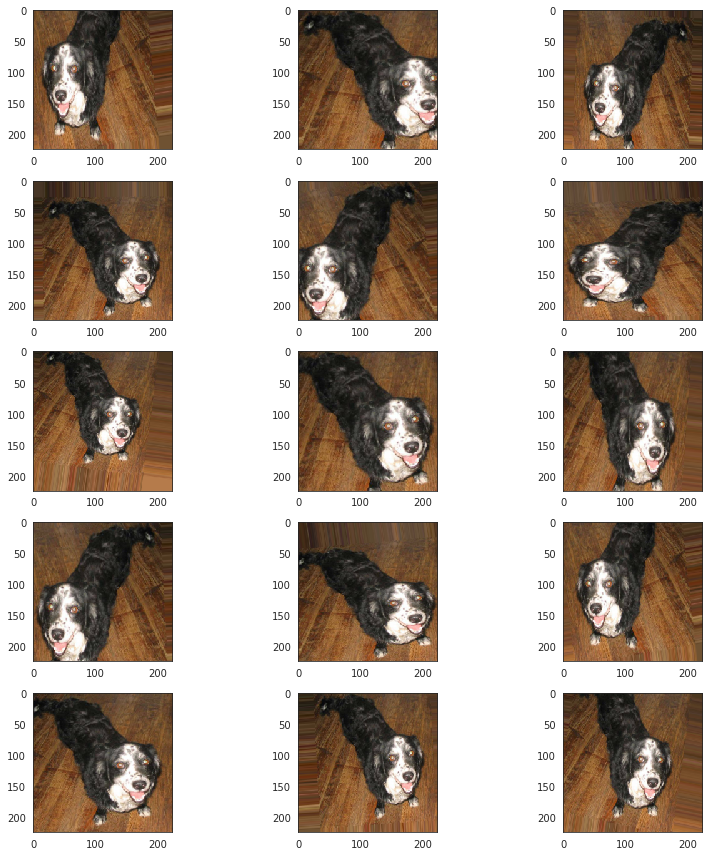

In [11]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

While using the Keras preprocessing utilities is very convenient, it is unfortunately not very fast and well-integrated with the TensorFlow ecosystem. Luckily, we can also apply these augmentation by using tensorflow functions and feeding the data into the model in the TensorFlow data set format.

In [12]:
# load the list of filenames as datasets
train_ds = tf.data.Dataset.from_tensor_slices(data_path + train_df.filename.values)
validate_ds = tf.data.Dataset.from_tensor_slices(data_path + validate_df.filename.values)
test_ds = tf.data.Dataset.from_tensor_slices(data_path + test_df.filename.values)


for f in train_ds.take(5):
  print(f.numpy())

b'./data/train/cat.8410.jpg'
b'./data/train/dog.12008.jpg'
b'./data/train/dog.6125.jpg'
b'./data/train/cat.8437.jpg'
b'./data/train/dog.5051.jpg'


Now we can implement the augmentation functions.

In [0]:
@tf.function(experimental_relax_shapes=True)
def augment(img):
    """Apply random horizontal flipping, rotation, shearing, 
    shifting, zooming, and change of brightness, contrats,
    and saturation. The scaling factors are all random,
    look at the individual lines to see the boundaries.
    
    Args:
        img: Image
    Returns:
        Augmented image
    """
        
    # horizontal flipping    
    img = tf.image.random_flip_left_right(img)
    
    # rotation
    img = tfa.image.rotate(img, tf.random.uniform((1,),-0.2,0.2)[0], interpolation='BILINEAR')
    
    # shearing
    shear_lambda = tf.random.uniform((1,),-0.1,0.1)[0]
    forward_transform = [[1.0,shear_lambda,0],[0,1.0,0],[0,0,1.0]]
    t = tfa.image.transform_ops.matrices_to_flat_transforms(tf.linalg.inv(forward_transform))
    img = tfa.image.transform(img, t, interpolation="BILINEAR")
    
    # shifting
    trans = tf.random.uniform((1,),-0.1,0.1)[0]
    img = tfa.image.translate(img, translations=[trans,trans])
    
    # zoom by cropping and resizing
    offset = tf.random.uniform((1,),0.0,0.1)[0]
    shift = tf.random.uniform((1,),0.9,1.0)[0]
    img_crp = tf.image.crop_and_resize(tf.reshape(img,[1,img.shape[0],img.shape[1],3]), 
                                       boxes=[[offset,offset,shift,shift]],
                                       box_indices=[0],
                                       crop_size=[img.shape[0], img.shape[1]])
    img = tf.reshape(img_crp,[img.shape[0],img.shape[1],3])
    
    # change brightness, contrast, and saturation
    img = tf.image.adjust_brightness(img, tf.random.uniform((1,),-0.2,0.2)[0])
    img = tf.image.adjust_contrast(img, contrast_factor=1+tf.random.uniform((1,),-0.1,0.1)[0])
    img = tf.image.adjust_saturation(img,1+tf.random.uniform((1,),-0.2,0.2)[0])
    
    return img



Now we'll have to write some functions to get the labels and convert the images to tensors.

In [0]:
@tf.function(experimental_relax_shapes=True)
def get_label(file_path):
  # convert the path to a list of path components
    parts = tf.strings.split(file_path, "/")
    parts = tf.strings.split(parts[-1], ".")
    # note that we output [[1],[0]] for dog and [[0],[1]] for cat
    # because we will fit with binary cross entropy loss.
    # we could also output [[1]] or [[0]] respectively,
    # if we use sparse categorical cross entropy
    if parts[0] == "dog":
        return np.array([1,0]).reshape(-1,1)
    else:
        return np.array([0,1]).reshape(-1,1)

@tf.function    
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMAGE_WIDTH, IMAGE_HEIGHT])

@tf.function
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

@tf.function
def process_path_aug(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    img = augment(img)
    return img, label

train_aug_ds = train_ds.map(process_path_aug, num_parallel_calls=AUTOTUNE)
train_noaug_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
validate_ds = validate_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

Okay, let's have a look if tigs are in the right shape.

In [15]:
for img, label in train_aug_ds.take(2):
  print("Image shape: ", img.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [[0]
 [1]]
Image shape:  (224, 224, 3)
Label:  [[1]
 [0]]


And let's see how the augmented vs. unaugmented image looks like.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


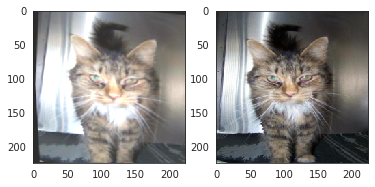

In [16]:
for img, label in train_aug_ds.take(1):
        img1 = img
for img, label in train_noaug_ds.take(1):
        img2 = img
        
plt.figure()
plt.subplot(1,2,1)
plt.imshow(img1)
plt.subplot(1,2,2)
plt.imshow(img2)
plt.show()

Now the last step is to prepare the data sets for training by shuffling, batching, and prefetching.

In [0]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    #  If the data set is too large to fit in memory then use 
    # `.cache(filename)` to cache preprocessing work for datasets 
    #  that don't fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
    else:
        ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  
    # Repeat forever
    ds = ds.repeat()
  
    ds = ds.batch(BATCH_SIZE)
  
    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)
  
    return ds

train_aug_ds = prepare_for_training(train_aug_ds)
train_noaug_ds = prepare_for_training(train_noaug_ds)
validate_ds = prepare_for_training(validate_ds)
test_ds = prepare_for_training(test_ds)

## Building the models
We can finally focus on the model. As already mentioned in the title of this notebook, we want to use a ResNet or residual network, developed by [He et al.](https://github.com/KaimingHe/deep-residual-networks). This type of network won the ILSVRC 2015 challenge with a top-5 error rate under 3.6%. The special design of this network includes residual units with skip connections. These connections basically skip a layer of the network and feed the signal directly into a layer that is higher up in the stack. Why is that useful at all? When a network is initialized with weights close to zero, it will also output values close to zero. Layers that have not started learning can block the flow of backpropagation in the network which makes it difficult to train very deep networks. With skip connections, however, the network can just output its input and easily propagate a signal.

The more parameters we want to learn, the more data we need. Since we don't have an awful lot of data, we'll use a smaller ResNet architecture, the ResNet-34 for the model we're building from scratch. Later we'll compare it to a pretrained ResNet-50. Let's build a class for the residual units first.

In [0]:
from functools import partial

# This will be the default convolutional layer with a 3x3 filter moving with a stride of 1 and
# applying SAME padding (padding the input with zeroes so that the output has the same shape)
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,padding="SAME", use_bias=False)

# this will be the class for a residual unit layer
class ResidualUnit(keras.layers.Layer):

    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        
        # The main layers: 2 convolutional layers (the first one may have a larger stride),
        # with batch normalization after each layer
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        
        # if the stride is 2, the output dimensions will be halved so 
        # we need a 1x1 convolutional layer with a stride of 2 to 
        # adjust the output dimensions of the skip connection
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]
    
    def call(self, inputs):
        # propagate the input through the main and skip layers (if present)
        # and return the sum of the two outputs through the activation fucntion
        main = inputs
        for layer in self.main_layers:
            main = layer(main)
        
        skip = inputs
        for layer in self.skip_layers:
            skip = layer(skip)
        
        return self.activation(main + skip)

Now we can use this residual unit to build a residual network with it.

In [0]:
# get the input shape
inp, _ = next(iter(train_aug_ds.take(1)))
input_shape = inp.numpy().shape[1:]

# set up the model
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=input_shape))

# initial convolutional layer
model.add(DefaultConv2D(64, kernel_size=7, strides=2))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))

# Every few steps we go deeper down the network, we will double the
# number of filter maps and reduce the dimensions of the output by
# applying a stride of 2. 
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
    
# apply global average pooling and feed the output directly into 
# the output layer which has a sigmoid activation
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(2, activation="sigmoid"))

# compile the model with Nadam optimizer
optimizer = keras.optimizers.Nadam()
model.compile(optimizer=optimizer,loss="binary_crossentropy",metrics=["accuracy"])


In [20]:
history = model.fit(train_aug_ds, 
                        steps_per_epoch=15000//BATCH_SIZE,
                        validation_data=validate_ds,
                        validation_steps=5000//BATCH_SIZE,
                        epochs=1)

Train for 234 steps, validate for 78 steps
234/234 [==============================] - 295s 1s/step - loss: 0.6947 - accuracy: 0.6079 - val_loss: 0.7266 - val_accuracy: 0.5571


In [21]:
model.save("ResNet34_save")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ResNet34_save/assets


Okay, only one period didn't give us amazing accuracy. Let's train the model until we don't gain any additional validation loss improvement by implementing an early stopping callbak.

In [22]:
# early stopping callback to prevent overfitting on the  training data
earlystop_cb = keras.callbacks.EarlyStopping(patience=2,
                                             min_delta=0.01,
                                             restore_best_weights=True,
                                             verbose=1)
history2 = model.fit(train_aug_ds, 
                     steps_per_epoch=15000//BATCH_SIZE,
                     validation_data=validate_ds,
                     validation_steps=5000//BATCH_SIZE,
                    epochs=100,callbacks=[earlystop_cb])

Train for 234 steps, validate for 78 steps
Epoch 1/100
234/234 [==============================] - 262s 1s/step - loss: 0.6049 - accuracy: 0.6701 - val_loss: 0.8103 - val_accuracy: 0.5921
Epoch 2/100
234/234 [==============================] - 248s 1s/step - loss: 0.5449 - accuracy: 0.7241 - val_loss: 0.6400 - val_accuracy: 0.6834
Epoch 3/100
234/234 [==============================] - 249s 1s/step - loss: 0.4874 - accuracy: 0.7682 - val_loss: 0.8053 - val_accuracy: 0.6216
Epoch 4/100
234/234 [==============================] - 251s 1s/step - loss: 0.4243 - accuracy: 0.8079 - val_loss: 0.7702 - val_accuracy: 0.7420
Epoch 00004: early stopping


In [0]:
model.save("ResNet34_save")

That's pretty great already, we got a validation accuracy of about 75%. Now let's see if we can even improve that by using a ResNet-50 pretrained on the ImageNet data set. Of course we'll have to remove the top layer of this pretrained model and add the one suitable for our classification task. We'll first freeze the weights of the lower layers, train the upper layers, and then gradually try to unfreeze some of the lower layers.

In [0]:
# get the pretrained ResNet50
base_model = keras.applications.resnet.ResNet50(weights="imagenet",include_top=False)

In [0]:
base_model = keras.applications.resnet.ResNet50(weights="imagenet",include_top=False)
# now we'll add global average pooling and the output layer on top of the base model
avgpool = keras.layers.GlobalAvgPool2D()(base_model.output)
flatten = keras.layers.Flatten()(avgpool)
output = keras.layers.Dense(2, activation="sigmoid")(flatten)
model2 = keras.models.Model(inputs=base_model.input, outputs=output)

# freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# compile the model with Nadam optimizer and dynamic loss scale
model2.compile(optimizer=optimizer,loss="binary_crossentropy",metrics=["accuracy"])

Okay, let's train it.

In [26]:
# early stopping callback to prevent overfitting on the  training data
earlystop_cb = keras.callbacks.EarlyStopping(patience=2,
                                             min_delta=0.01,
                                             restore_best_weights=True,
                                             verbose=1)

history3 = model2.fit(train_aug_ds, 
                    steps_per_epoch=15000//BATCH_SIZE,
                    validation_data=validate_ds,
                    validation_steps=5000//BATCH_SIZE,
                    epochs=100,callbacks=[earlystop_cb])

Train for 234 steps, validate for 78 steps
Epoch 1/100
234/234 [==============================] - 276s 1s/step - loss: 0.1193 - accuracy: 0.9547 - val_loss: 1.4036 - val_accuracy: 0.5098
Epoch 2/100
234/234 [==============================] - 246s 1s/step - loss: 0.0752 - accuracy: 0.9704 - val_loss: 1.6608 - val_accuracy: 0.5090
Epoch 3/100
234/234 [==============================] - 245s 1s/step - loss: 0.0707 - accuracy: 0.9735 - val_loss: 1.4818 - val_accuracy: 0.5094
Epoch 00003: early stopping


Mhh, the model severly overfitted on the training data. Let's try to unfreeze the layers and introduce a dropout layer.

In [27]:
base_model = keras.applications.resnet.ResNet50(weights="imagenet",include_top=False)
# now we'll add global average pooling and the output layer on top of the base model
dropout1 = keras.layers.Dropout(0.5)(base_model.output)
avgpool = keras.layers.GlobalAvgPool2D()(dropout1)
flatten = keras.layers.Flatten()(avgpool)
dropout2 = keras.layers.Dropout(0.5)(flatten)
output = keras.layers.Dense(2, activation="sigmoid")(dropout2)
model3 = keras.models.Model(inputs=base_model.input, outputs=output)

# freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers[-31:]:
    layer.trainable = True

# compile the model with Nadam optimizer and dynamic loss scale
model3.compile(optimizer=optimizer,loss="binary_crossentropy",metrics=["accuracy"])

earlystop_cb = keras.callbacks.EarlyStopping(patience=2,
                                             min_delta=0.01,
                                             restore_best_weights=True,
                                             verbose=1)

history4 = model3.fit(train_aug_ds, 
                    steps_per_epoch=15000//BATCH_SIZE,
                    validation_data=validate_ds,
                    validation_steps=5000//BATCH_SIZE,
                    epochs=100,callbacks=[earlystop_cb])

Train for 234 steps, validate for 78 steps
Epoch 1/100
234/234 [==============================] - 281s 1s/step - loss: 0.0807 - accuracy: 0.9694 - val_loss: 0.6941 - val_accuracy: 0.5021
Epoch 2/100
234/234 [==============================] - 250s 1s/step - loss: 0.0461 - accuracy: 0.9820 - val_loss: 0.6952 - val_accuracy: 0.4909
Epoch 3/100
234/234 [==============================] - 250s 1s/step - loss: 0.0361 - accuracy: 0.9863 - val_loss: 0.6972 - val_accuracy: 0.4895
Epoch 00003: early stopping
Train for 234 steps, validate for 78 steps
Epoch 1/100
234/234 [==============================] - 281s 1s/step - loss: 0.0807 - accuracy: 0.9694 - val_loss: 0.6941 - val_accuracy: 0.5021
Epoch 2/100
234/234 [==============================] - 250s 1s/step - loss: 0.0461 - accuracy: 0.9820 - val_loss: 0.6952 - val_accuracy: 0.4909
Epoch 3/100
234/234 [==============================] - 250s 1s/step - loss: 0.0361 - accuracy: 0.9863 - val_loss: 0.6972 - val_accuracy: 0.4895
Epoch 00003: early sto

Okay, look like reusing a pretrained model doesn't work well here. The overfitting is too severe. But hey, the model we trained from scrathc was already doing pretty well, so kind of a success :)